In [1]:
%run Solution.ipynb

In [2]:
def calculate_delta_r9(T):
    return G0('AlCl3', T) + G0('NH3', T) - G0('AlN', T) - 3 * G0('HCl', T)

def calculate_delta_r10(T):
    return G0('GaCl', T) + G0('NH3', T) - G0('GaN', T) - G0('HCl', T) - G0('H2', T)

In [3]:
Pa = 100000

def K9(T, R = 8.314):
    return math.exp(-1 * calculate_delta_r9(T) / (R * T)) / Pa

def K10(T, R = 8.314):
    return math.exp(-1 * calculate_delta_r10(T) / (R * T))

In [4]:
T = 1100.0 + 273.15
print(K9(T))
print(K10(T))

1.2891721396749681e-08
0.5918031945339368


In [5]:
print(D('NH3', T))
print(D('GaCl', T))
print(D('AlCl3', T))
print(D('HCl', T))
print(D('H2', T))

0.0011397438470300157
0.0007069071048692108
0.0005660531726691359
0.0010160243837422209
0.003253633515633444


In [6]:
def PG1(xg):
    return {
       'NH3':1500,
       'GaCl':(30 * (1 - xg)),
       'AlCl3':(30 * xg),
       'H2':0,
       'HCl':0,
       'N2':98470,
    }

def PG2(xg):
    return {
       'NH3':1500,
       'GaCl':(30 * (1 - xg)),
       'AlCl3':(30 * xg),
       'H2':98470 * 0.1,
       'HCl':0,
       'N2':98470 * 0.9,
    }


def solve(xg, pgGen, solve = [1, 1, 1, 1, 1, 1]):
    PG = pgGen(xg)
    
    x, AlCl3, GaCl, NH3, HCl, H2 = sy.symbols('x AlCl3 GaCl NH3 HCl H2')
    Xmat = sy.Matrix([
        AlCl3 * NH3 - K9(T) * x * (HCl)**3,
        GaCl * NH3 - K10(T) * (1 - x) * HCl * H2,
        D('HCl', T) * (PG['HCl'] - HCl) + 2 * D('H2', T) * (PG['H2'] - H2) + 3 * D('NH3', T) * (PG['NH3'] - NH3),
        3 * D('AlCl3', T) * (PG['AlCl3'] - AlCl3) + D('GaCl', T) * (PG['GaCl'] - GaCl) + D('HCl', T) * (PG['HCl'] - HCl),
        D('AlCl3', T) * (PG['AlCl3'] - AlCl3) + D('GaCl', T) * (PG['GaCl'] - GaCl) - D('NH3', T) * (PG['NH3'] - NH3),
        (1 - x) * D('AlCl3', T) * (PG['AlCl3'] - AlCl3) - x * D('GaCl', T) * (PG['GaCl'] - GaCl),
        
    ])
    
    Y = [x, AlCl3, GaCl, NH3, HCl, H2]
    ans = newton_method(Xmat * 10**50, Y, solve)
    ans1 = [0] * 3
    ans1[0] = ans[0]
    ans1[1] = D('AlCl3', T) * (PG['AlCl3'] - ans[1]) / (8314 * T * 0.01)
    ans1[2] = D('GaCl', T) * (PG['GaCl'] - ans[2]) / (8314 * T * 0.01)
    return ans1


In [7]:
import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed

def findPoints():
    
    XGs = [0.0, 0.0125, 0.025, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    Xs1 = Parallel(n_jobs=8)(delayed(solve)(xg,PG1) for xg in XGs)
    Xs2 = Parallel(n_jobs=8)(delayed(solve)(xg,PG2) for xg in XGs)
    return XGs, Xs1, Xs2

In [8]:
XGs, Xs1, Xs2 = findPoints()

### Построим диаграммы вхождения Алюминия в кристалл

In [9]:
def drawDiagram(XGs, Xs, ind):
    plt.figure(figsize=(10,10))
    a = []
    for i in range(len(Xs)):
        a.append(Xs[i][ind])
    plt.plot(XGs, a)
    plt.xlabel('xg', fontsize=15)
    if (ind == 0):
        plt.ylabel('x', fontsize=15)
    if (ind == 1):
        plt.ylabel('AlCl3 кмоль/(м2*сек)', fontsize=15)
    if (ind == 2):
        plt.ylabel('GaCl кмоль/(м2*сек)', fontsize=15)
    plt.show()

#### Первый случай: несущий газ - чистый $N_2$
<div>
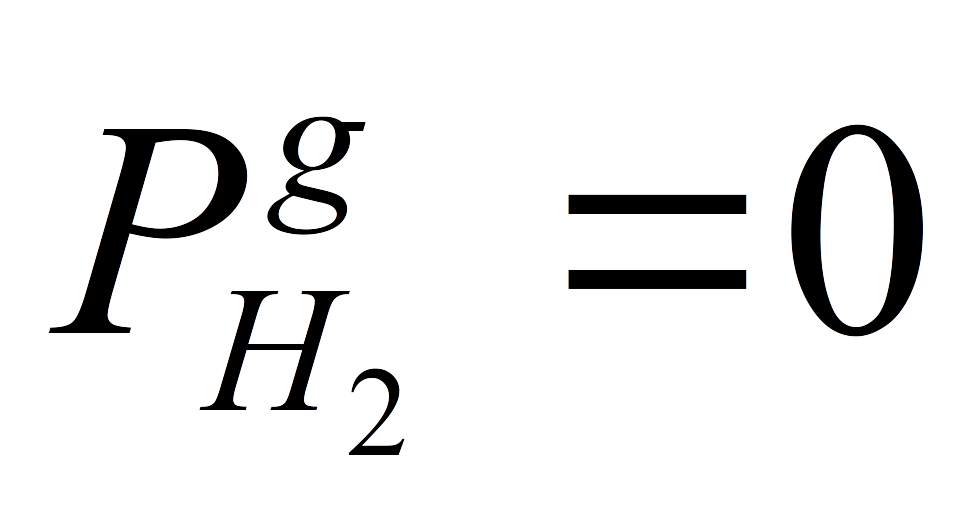
</div>

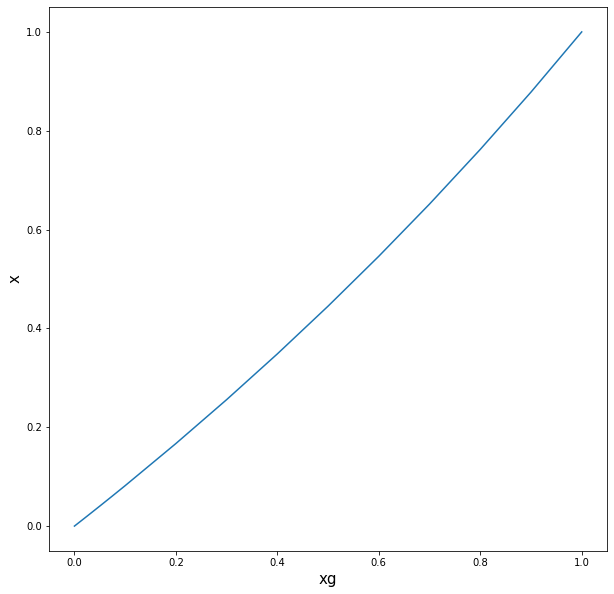

In [10]:
drawDiagram(XGs, Xs1, 0)

#### Второй случай: несущий газ - 10%-ая смесь $H_2$ и $N_2$
<div>

</div>

Из графиков мы видим, что в первом случае график вхождения Al в кристалле близок к линейному, а во втором представляет собой сильно выпуклую линию (доля алюминия в кристалле резко превышает долю AlCl3 в газообразных хлоридах). 

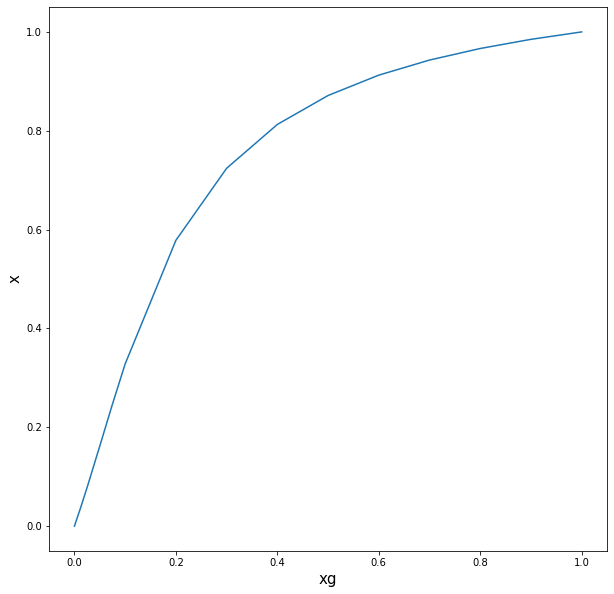

In [11]:
drawDiagram(XGs, Xs2, 0)

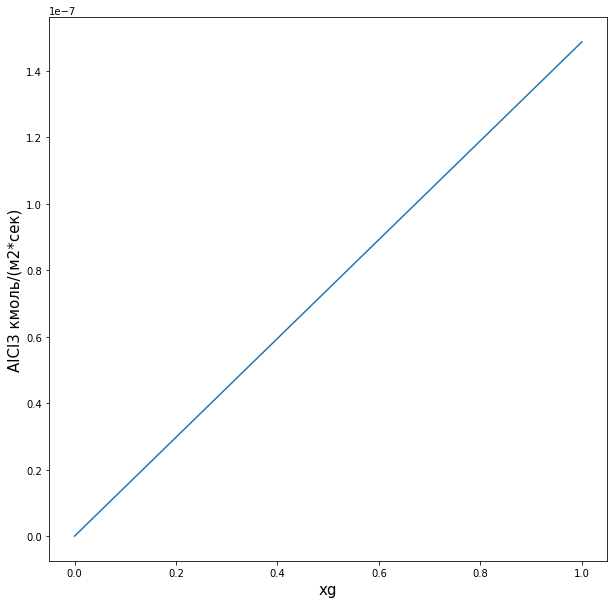

In [12]:
drawDiagram(XGs, Xs1, 1)

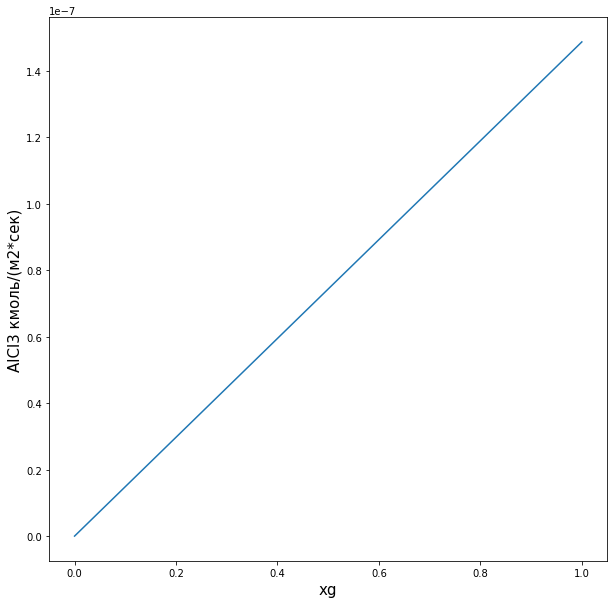

In [13]:
drawDiagram(XGs, Xs2, 1)

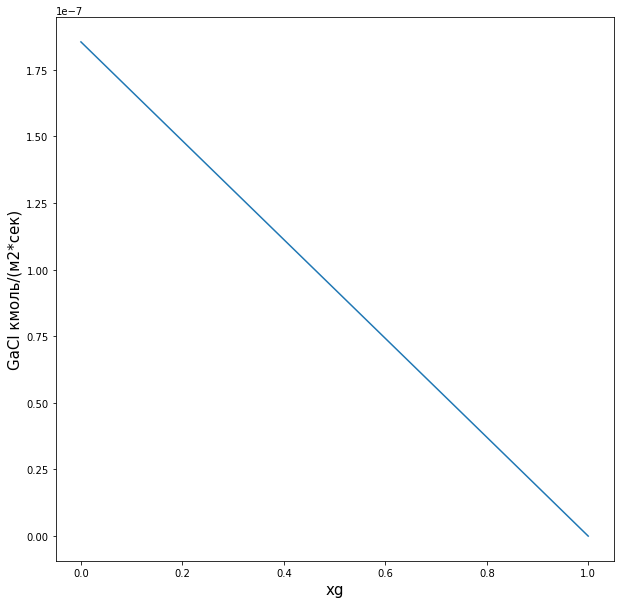

In [14]:
drawDiagram(XGs, Xs1, 2)

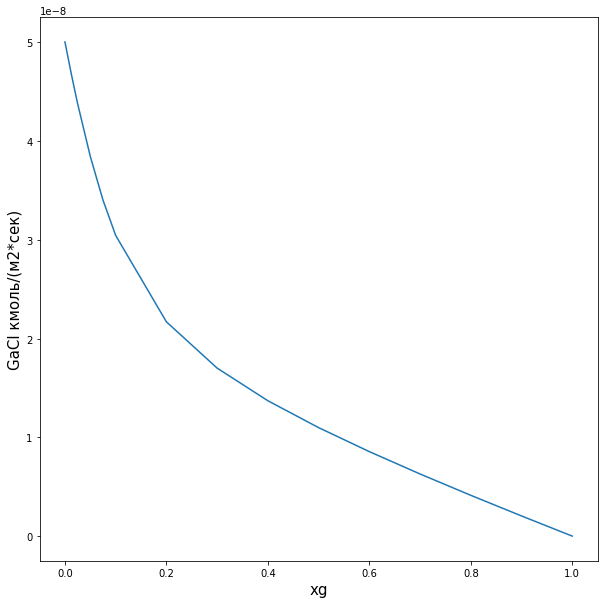

In [15]:
drawDiagram(XGs, Xs2, 2)

Маленькое добавление H2 резко замедляет реакцию R10, что влечет вхождение Ga в вещество, но никак не задевает реакцию R9, ответсвенную за вхождение аллюиминия. Этим и объясняется изменение графика при добавлении малого кол-ва H2.

Полученные результаты согласуются с экспреиментальными данными работы.

Можем заметить, что добавление H2 никак не влияет на парциальный поток G_AlCl3, но очень сильно уменьшает поток GaCl